In [140]:
import os
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from anatomy.anatomy_api import AnatomyApi
from matplotlib import ticker

from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from allensdk.api.queries.ontologies_api import OntologiesApi

%matplotlib inline

In [11]:
aapi = AnatomyApi()
ss = aapi.get_summary_structure_data('id')
mcc = MouseConnectivityCache(
    manifest_file = '../connectivity/mouse_connectivity_manifest.json')
structure_tree = mcc.get_structure_tree()
isocortex = structure_tree.get_structures_by_acronym(['Isocortex'])[0]
#cla = structure_tree.get_structures_by_acronym(['CLA'])[0]['id']
#HPF = structure_tree.get_structures_by_acronym(['HPF'])[0]
iso = structure_tree.descendant_ids([isocortex['id']])[0]
iso = [structure for structure in iso if structure in ss]
#hipp = structure_tree.descendant_ids([HPF['id']])[0]
#hipp = [structure for structure in hipp if structure in ss]
ia_map = structure_tree.get_id_acronym_map()
ai_map = {value:key for key, value in ia_map.items()}
ctx_strs = [ai_map[structure] for structure in iso]
#hipp_strs = [ai_map[structure] for structure in hipp]
valid_strs = ctx_strs

In [15]:
plot_order = ['ACAd', 'ACAv', 'PL', 'ILA', 'ORBl', 'ORBm', 'ORBvl', 'VISa', 'VISam', 
              'RSPagl', 'RSPd', 'RSPv', 'SSp-tr', 'SSp-ll', 'MOs',
              'SSs', 'SSp-bfd', 'SSp-ul', 'SSp-un', 'SSp-n', 'SSp-m', 'MOp',
              'FRP', 'VISpm', 'AId', 'AIv', 'AIp', 'GU', 'VISC', 'TEa', 'PERI', 'ECT', 
              'VISal', 'VISl', 
              'VISp', 'VISpl', 'VISli', 'VISpor', 'VISrl', 'AUDd', 'AUDp', 'AUDpo', 'AUDv']

In [19]:
ss_isohipp = [ia_map[structure] for structure in plot_order]

In [20]:
print(ss_isohipp)

[39, 48, 972, 44, 723, 731, 746, 312782546, 394, 894, 879, 886, 361, 337, 993, 378, 329, 369, 182305689, 353, 345, 985, 184, 533, 104, 119, 111, 1057, 677, 541, 922, 895, 402, 409, 385, 425, 312782574, 312782628, 417, 1011, 1002, 1027, 1018]


In [21]:
import platform
if platform.system() == 'Darwin':
    path = '/Users/jenniferwh/Dropbox/DMN paper/fMRI data from Alessandro/ICA_map_final_CCF/distance_glm_data'
    savepath = '/Users/jenniferwh/Dropbox (Allen Institute)/Mesoscale Connectome Papers in Progress/2019 DMN/_new_figures/Figure_S6'
if platform.system() == 'Windows':
    path = r'C:\Users\jenniferwh\Dropbox\DMN paper\fMRI data from Alessandro\ICA_map_final_CCF\distance_glm_data'
    savepath = r''

In [22]:
dat = pd.read_csv(os.path.join(path, 'cortical_CAV_data_with_DMN_coeff.csv'))

In [161]:
td_dat.keys()

Index(['Unnamed: 0', 'id', 'primary_CAV_inj_acronym', 'primary_CAV_inj_str',
       'secondary_CAV_inj_acronym', 'secondary_CAV_inj_str', 'CAV_size',
       'in_DMN', 'out_DMN', 'percent_DMN', 'gender', 'structure-abbrev',
       'structure-id', 'structure-name'],
      dtype='object')

In [195]:
def make_projection_matrix(source, td_dat, wt=False):
    data_type = 'normalized_projection_volume'
    epsilon = (10**-1.5)/2 #0.5*threshold value
    if isinstance(wt, pd.DataFrame):
        pm_wt = mcc.get_projection_matrix(experiment_ids = wt['id'], 
                                       projection_structure_ids = ss_isohipp,
                                       hemisphere_ids= [2], # right hemisphere, ipsilateral
                                       parameter = data_type)
        pm_td = mcc.get_projection_matrix(experiment_ids = td_dat['id'], 
                                       projection_structure_ids = ss_isohipp,
                                       hemisphere_ids= [1], # left hemisphere, ipsilateral
                                       parameter = data_type)
        row_labels = ['wt'] * len(wt['id']) + list(td_dat['structure-abbrev'].values)
        row_labels = np.array(row_labels)
        sorted_index = np.argsort(row_labels)
        row_labels = row_labels[sorted_index]
        row_labels = [str(value) for value in wt['id'].values] + [
            str(value) for value in td_dat['id'].values]
        '''
        row_labels = ['ORBl$_{VISal}$', 'ORBl$_{ACAd}$', 'ORBl$_{Rbp4}$', 
                      'ORBl$_{WT}$', 'ORBl$_{WT}$', 'ORBl$_{WT}$', 'ORBl$_{WT}$']
        '''
        column_labels = [ c['label'] for c in pm_td['columns'] ] 
        #matrix = np.concatenate((pm_wt['matrix'], pm_td['matrix']), axis = 0)
        matrix = np.concatenate((np.log10(pm_wt['matrix'] + epsilon), 
                                 np.log10(pm_td['matrix'] + epsilon)), axis = 0)
    
    else:
        pm = mcc.get_projection_matrix(experiment_ids = td_dat['id'], 
                                   projection_structure_ids = ss_isohipp,
                                   hemisphere_ids= [1], # left hemisphere, ipsilateral
                                   parameter = data_type)
        row_labels = td_dat['structure-abbrev'].values
        row_labels = ['ORBl']
        row_labels = np.array(row_labels)
        sorted_index = np.argsort(row_labels)
        row_labels = row_labels[sorted_index]
        column_labels = [ c['label'] for c in pm['columns'] ] 
        matrix = np.log10(pm['matrix'] + epsilon)
    matrix[np.isnan(matrix)] = 0
    matrix = matrix[sorted_index]
    plot_matrix(source, data_type, epsilon, matrix, row_labels, column_labels)
    
def plot_matrix(source, data_type, epsilon, matrix, row_labels, column_labels):
    fig, ax = plt.subplots(figsize=(19,len(matrix)/2.5))
    heatmap = ax.pcolor(matrix, cmap='Greys')
    # put the major ticks at the middle of each cell
    ax.set_xticks(np.arange(matrix.shape[1])+0.5, minor=False)
    ax.set_yticks(np.arange(matrix.shape[0])+0.5, minor=False)

    ax.set_xlim([0, matrix.shape[1]])
    ax.set_ylim([0, matrix.shape[0]])          

    # want a more natural, table-like display
    ax.xaxis.tick_top()
    plt.xticks(rotation=90)
    
    # Remove the -L from column labels
    target_labels = []
    for label in column_labels:
        target_labels.append(label[:-2])

    ax.set_xticklabels(target_labels, minor=False)
    ax.set_yticklabels(row_labels, minor=False)
    
    cbar = fig.colorbar(heatmap, ax = ax, orientation='vertical', fraction=0.08, pad=0.01)
    cbar_ax = fig.axes[-1]
    cbar_solids = cbar_ax.collections[0]
    cbar_solids.set_edgecolor("face")
    tick_locator = ticker.MaxNLocator(nbins=len(matrix))
    ticklabs = cbar.ax.get_yticklabels()
    cbar.ax.set_yticklabels(ticklabs, fontsize=10)
    cbar.locator = tick_locator
    cbar.update_ticks()
    
    __file__ = os.path.join(savepath, '%s_matrix_%s_epsilon_%s'%(source, data_type, 
                                                                 round(epsilon, 3)))
    plt.savefig(__file__+".pdf", bbox_inches='tight', pad_inches=0.3, dpi=300)
    plt.show()

# Plot matrices by source

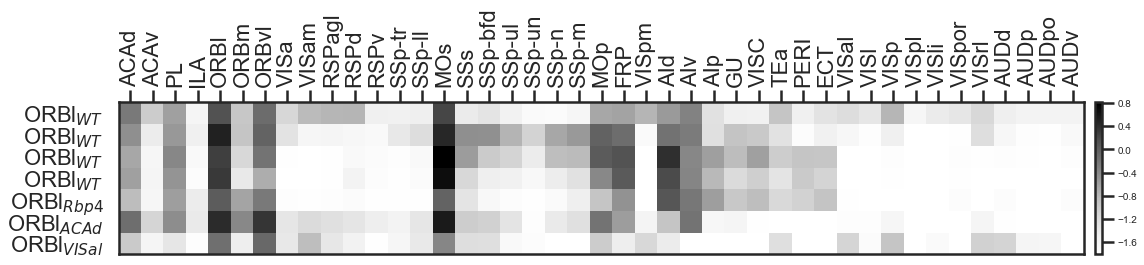

In [194]:
source_structure = 'ORBl'
td_dat = dat[dat['structure-abbrev'] == source_structure]
td_dat = dat[dat['id'].isin([571816813, 601804603])]
source = structure_tree.get_structures_by_acronym([source_structure])[0]
try:
    wt = mcc.get_experiments(cre=False, injection_structure_ids=[source['id']], 
                             dataframe=True)
    wt2 = mcc.get_experiments(cre =['Emx1-IRES-Cre','Rbp4-Cre_KL100'],
                            injection_structure_ids = [source['id']], dataframe = True)
    wt = pd.concat([wt, wt2])
except:
    wt = False
make_projection_matrix(source_structure, td_dat, wt)

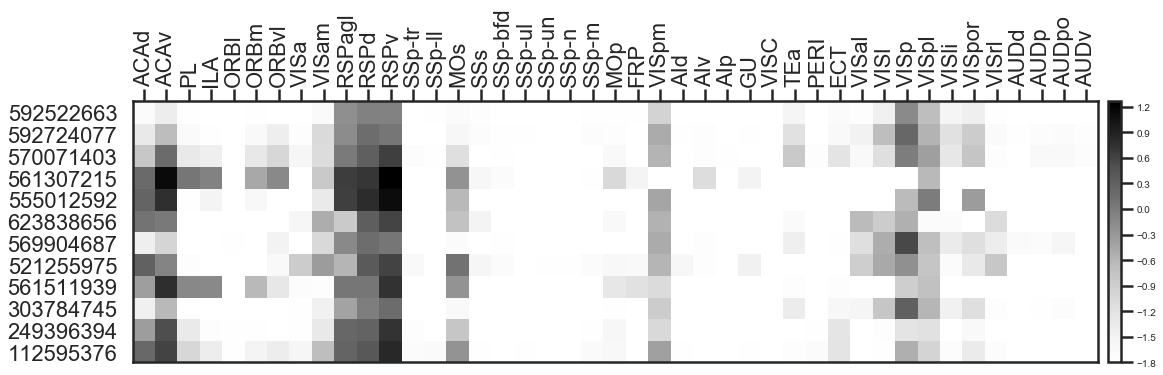

In [196]:
source_structure = 'RSPv'
td_dat = dat[dat['structure-abbrev'] == source_structure]
td_dat = dat[dat['id'].isin([521255975, 555012592, 561511939, 570071403, 592522663,
                             623838656, 569904687, 868641659, 592724077, 666090944,
                             561307215])]
source = structure_tree.get_structures_by_acronym([source_structure])[0]
try:
    wt = mcc.get_experiments(cre=False, injection_structure_ids=[source['id']], 
                             dataframe=True)
    wt = wt[wt['id'] == 112595376]
    wt2 = mcc.get_experiments(cre =['Emx1-IRES-Cre','Rbp4-Cre_KL100'],
                            injection_structure_ids = [source['id']], dataframe = True)
    wt2 = wt2[wt2['id'].isin([303784745, 249396394])]
    wt = pd.concat([wt, wt2])
except:
    wt = False
make_projection_matrix(source_structure, td_dat, wt)

## Stopping here for now

# Make matrices for all sources

In [27]:
dat['structure-abbrev'].unique()

array(['VISl', 'ILA', 'VISp', 'ENTl', 'ENTm', 'ACAd', 'RSPv', 'PL',
       'VISam', 'ORBvl', 'VISpm', 'VISpl', 'MOs', 'ACAv', 'VISrl',
       'VISpor', 'RSPagl', 'SSp-ll', 'TEa', 'AIv', 'ORBm', 'ECT', 'ORBl',
       'SSp-tr', 'RSPd', 'SUB', 'VISli', 'VISal', 'VISa'], dtype=object)

VISl


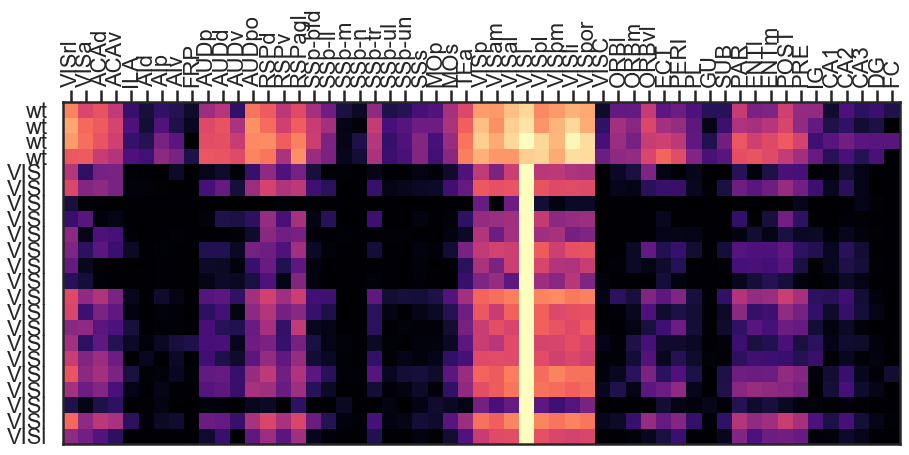

ILA


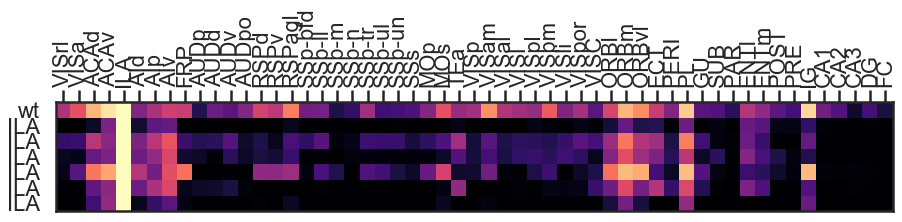

VISp


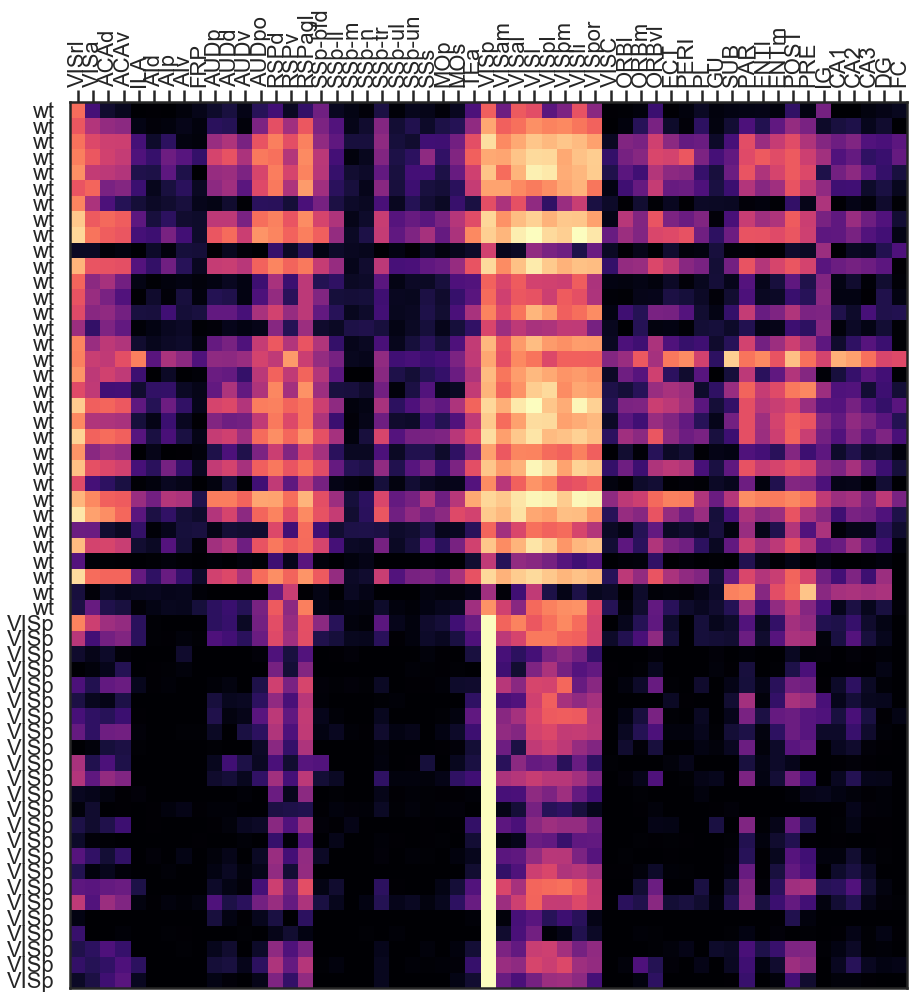

ENTl


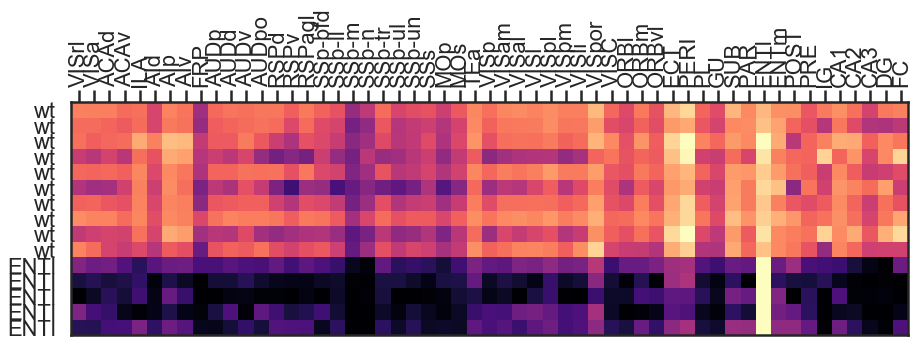

ENTm


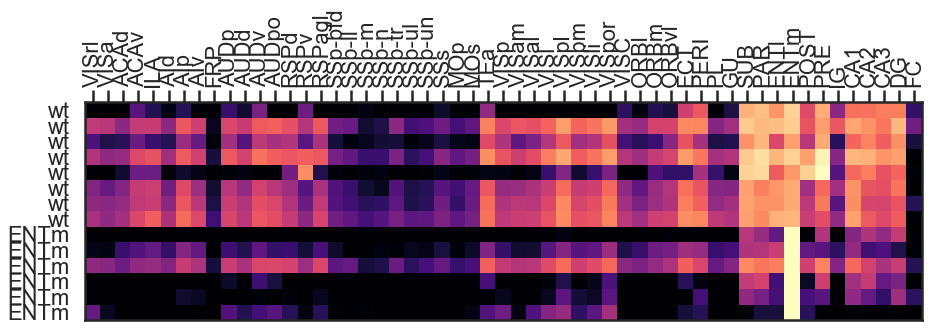

ACAd


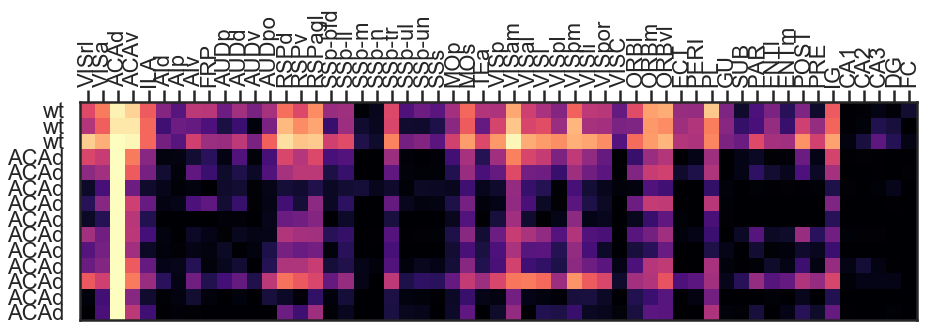

RSPv


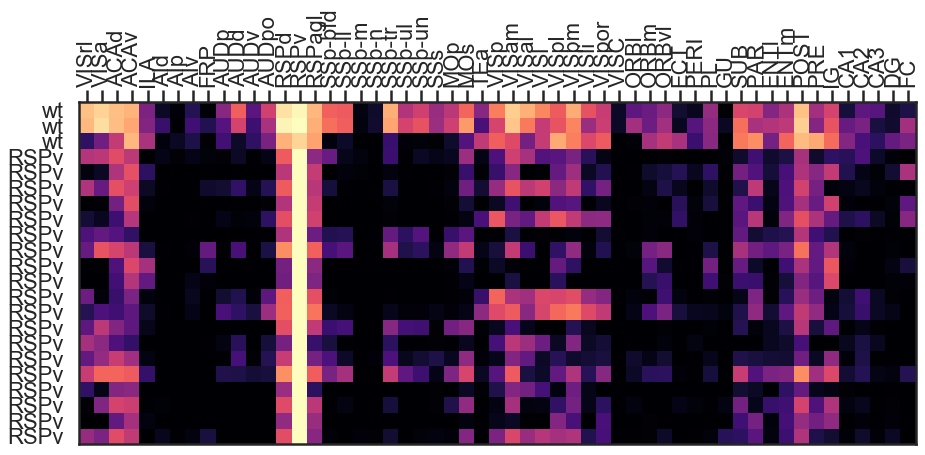

PL


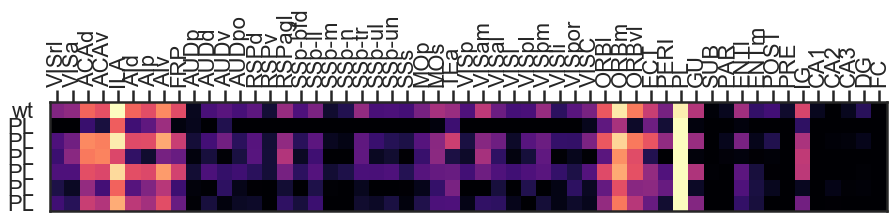

VISam


In [ ]:
for structure in dat['structure-abbrev'].unique():
    print(structure)
    source_structure = structure
    td_dat = dat[dat['structure-abbrev'] == source_structure]
    source = structure_tree.get_structures_by_acronym([source_structure])[0]
    try:
        wt = mcc.get_experiments(cre=False, injection_structure_ids=[source['id']], 
                                 dataframe=True)
    except:
        wt = False
    make_projection_matrix(source_structure, td_dat, wt)